In [93]:
!pip install h2o
%matplotlib inline
import random, os, sys
import h2o
import pandas
import pprint
import operator
import matplotlib
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from tabulate import tabulate
from h2o.automl import H2OAutoML
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##**Correlation of Dataset** (For later reference)

Check Happiness Rank Row Carefully !! 

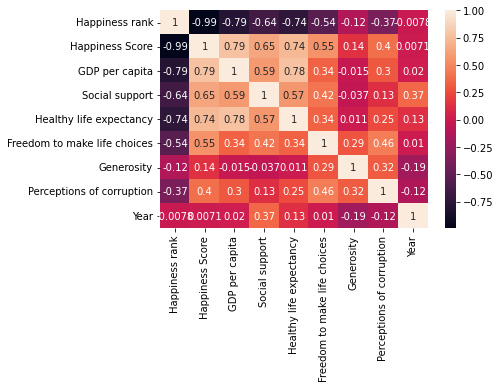

In [94]:
import seaborn as sns

data_for_corr = pd.read_csv(
    "https://raw.githubusercontent.com/aiskunks/The_Economics_of_Happiness/main/TEH/TEH_World_Happiness_2015_2019.csv"
)
sns.heatmap(data_for_corr.corr(), annot=True)

## H2O starts 

In [95]:
# Connect to a cluster or initialize it if not started
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 32 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_06zevv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.066 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [96]:
# set this to True if interactive (matplotlib) plots are desired
interactive = True
if not interactive:
    matplotlib.use("Agg", warn=False)
import matplotlib.pyplot as plt

In [97]:
## Please check we are importing dataset with H2O and not Pandas
data = h2o.import_file(
    "https://raw.githubusercontent.com/aiskunks/The_Economics_of_Happiness/main/TEH/TEH_World_Happiness_2015_2019.csv"
)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [98]:
data.describe()

Rows:782
Cols:10

,Country,Happiness rank,Happiness Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Year
type,enum,int,real,real,real,real,real,real,real,int
mins,,1.0,2.693000078,0.0,0.0,0.0,0.0,0.0,0.0,2015.0
mean,,78.69820971867004,5.379017902998721,0.9160474824757038,1.0783924825089533,0.6124155771253205,0.4110908258235294,0.21857584156138085,0.12527520997058825,2016.9936061381088
maxs,,158.0,7.769,2.096,1.644,1.141,0.724,0.838075161,0.55191,2019.0
sigma,,45.18238438270533,1.1274564601618513,0.4073401312916095,0.32954831933364276,0.2483086403761213,0.15288042062428447,0.12232074872244174,0.10584377164077122,1.4173644324240484
zeros,,0,0,5,5,5,5,5,7,0
missing,0,0,0,0,0,0,0,0,0,0
0,Switzerland,1.0,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,2015.0
1,Iceland,2.0,7.561,1.30232,1.40223,0.94784,0.62877,0.4363,0.14145,2015.0
2,Denmark,3.0,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,2015.0


In [99]:
# Data exploration and munging. Generate scatter plots


def scatter_plot(data, x, y, max_points=1000, fit=True):
    if fit:
        lr = H2OGeneralizedLinearEstimator(family="gaussian")
        lr.train(x=x, y=y, training_frame=data)
        coeff = lr.coef()
    df = data[[x, y]]
    runif = df[y].runif()
    df_subset = df[runif < float(max_points) / data.nrow]
    df_py = h2o.as_list(df_subset)

    if fit:
        h2o.remove(lr._id)

    # If x variable is string, generate box-and-whisker plot
    if df_py[x].dtype == "object":
        if interactive:
            df_py.boxplot(column=y, by=x)
    # Otherwise, generate a scatter plot
    else:
        if interactive:
            df_py.plot(x=x, y=y, kind="scatter")

    if fit:
        x_min = min(df_py[x])
        x_max = max(df_py[x])
        y_min = coeff["Intercept"] + coeff[x] * x_min
        y_max = coeff["Intercept"] + coeff[x] * x_max
        plt.plot([x_min, x_max], [y_min, y_max], "k-")
    if interactive:
        plt.show()

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


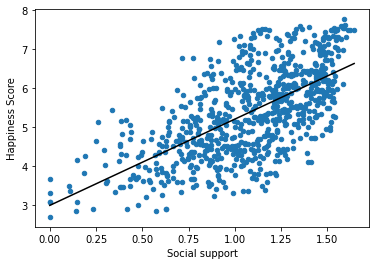

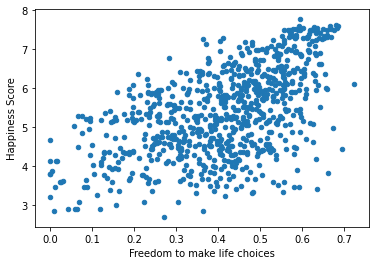

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


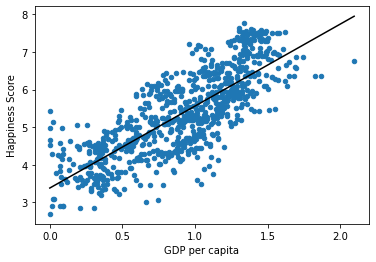

In [100]:
scatter_plot(data, "Social support", "Happiness Score", fit=True)
scatter_plot(
    data, "Freedom to make life choices", "Happiness Score", max_points=5000, fit=False
)

scatter_plot(data, "GDP per capita", "Happiness Score", max_points=5000, fit=True)

In [101]:
# Use the .group_by function to countries Happiness Score
grouped = data.group_by("Country")
bpd = grouped.count().sum("Happiness Score").frame
bpd.show()
bpd.describe()
bpd.dim

Country,nrow,sum_Happiness Score
Afghanistan,5,17.564
Albania,5,23.563
Algeria,5,28.338
Angola,4,15.489
Argentina,5,32.297
Armenia,5,21.966
Australia,5,36.381
Austria,5,35.71
Azerbaijan,5,26.146
Bahrain,5,30.569


Rows:170
Cols:3

,Country,nrow,sum_Happiness Score
type,enum,int,real
mins,,1.0,4.369
mean,,4.6,24.74348235379412
maxs,,5.0,37.729999836
sigma,,1.0343222347059453,7.746500942954384
zeros,,0,0
missing,0,0,0
0,Afghanistan,5.0,17.56399991
1,Albania,5.0,23.563000053000003
2,Algeria,5.0,28.338000217


[170, 3]

In [102]:
# Create a test/train split
train, test = data.split_frame([0.9])

In [103]:
#  Set response variable and your choice of predictor variables
myY = "Happiness Score"
myX = [
    "Happiness rank",
    "GDP per capita",
    "Social support",
    "Healthy life expectancy",
    "Freedom to make life choices",
    "Generosity",
    "Perceptions of corruption",
]

In [104]:
# Build simple GLM model
data_glm = H2OGeneralizedLinearEstimator(family="gaussian", standardize=True)
data_glm.train(x=myX, y=myY, training_frame=train, validation_frame=test)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1676328250563_55


GLM Model: summary
    family    link      regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.002213 )  7                             6                              1                       py_82_sid_9349

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.01783768688561546
RMSE: 0.13355780353695348
MAE: 0.09953891397732649
RMSLE: 0.02459206169357674
Mean Residual Deviance: 0.01783768688561546
R^2: 0.9856758528224379
Null degrees of freedom: 705
Residual degrees of freedom: 699
Null deviance: 879.1732439730956
Residual deviance: 12.593406941244517
AIC: -823.1267154100298

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.02118128212856257
RMSE: 0.145537906156996
MAE: 0.11455422881124566
RMSLE: 0.02613241619650685
Mean Residual Deviance: 0.02118128212856257
R^2: 0.985828436139162
Null degrees of freedom: 75
Residual degrees of freedom: 69
Null deviance: 113.6021915541116
Residual deviance: 1.6097774417707553
AIC: -61.27378579143134

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective           training_rmse        training_deviance    training_mae         training_r2         validation_rmse    validation_deviance    validation_mae       validation_r2
--  -------------------  ----------  ------------  -------------------------  ------------------  -------------------  -------------------  -------------------  ------------------  -----------------  ---------------------  -------------------  -----------------
    2023-02-14 01:16:51  0.000 sec   0             879.1732428947981          1.2452878794543885
    2023-02-14 01:16:51  0.004 sec   1                                                            0.13355780353695348  0.01783768688561546  0.09953891397732649  0.9856758528224379  0.145537906156996  0.02118128212856257    0.11455422881124566  0.985828436139162

Variable Importances: 
variable                      relative_importance    scaled_importance    percentage
----------------------------  ---------------------  -------------------  ------------
Happiness rank                1.06873                1                    0.926423
Perceptions of corruption     0.031729               0.0296884            0.027504
Social support                0.0203853              0.0190742            0.0176708
Generosity                    0.0147722              0.0138221            0.0128051
Healthy life expectancy       0.0100185              0.00937418           0.00868445
Freedom to make life choices  0.00797458             0.0074617            0.00691269
GDP per capita                0                      0                    0

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [105]:
# Build simple GBM model

data_gbm = H2OGradientBoostingEstimator(
    balance_classes=True, ntrees=10, max_depth=1, learn_rate=0.1, min_rows=2
)

data_gbm.train(x=myX, y=myY, training_frame=train, validation_frame=test)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,10.0,10.0,830.0,1.0,1.0,1.0,2.0,2.0,2.0
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2023-02-14 01:16:51,0.003 sec,0.0,1.1159247,0.9290530,1.2452879,1.2226061,1.0266235,1.4947657
,2023-02-14 01:16:51,0.042 sec,1.0,1.0399558,0.8420391,1.0815081,1.1456822,0.9343250,1.3125877
,2023-02-14 01:16:51,0.048 sec,2.0,0.9730432,0.7706511,0.9468131,1.0782074,0.8600186,1.1625312
,2023-02-14 01:16:51,0.057 sec,3.0,0.9124563,0.7063686,0.8325765,1.0162124,0.7927909,1.0326877
,2023-02-14 01:16:51,0.059 sec,4.0,0.8573780,0.6527924,0.7350971,0.9613201,0.7391616,0.9241364
,2023-02-14 01:16:51,0.061 sec,5.0,0.8074633,0.6064256,0.6519970,0.9098602,0.6916713,0.8278456
,2023-02-14 01:16:51,0.062 sec,6.0,0.7620529,0.5632896,0.5807247,0.8646736,0.6481642,0.7476604
,2023-02-14 01:16:51,0.069 sec,7.0,0.7197971,0.5286745,0.5181078,0.8197917,0.6116194,0.6720585


In [106]:
# Variable importances from each algorithm
# Calculate magnitude of normalized GLM coefficients
from six import iteritems

glm_varimp = data_glm.coef_norm()
for k, v in iteritems(glm_varimp):
    glm_varimp[k] = abs(glm_varimp[k])

# Sort in descending order by magnitude
glm_sorted = sorted(glm_varimp.items(), key=operator.itemgetter(1), reverse=True)
table = tabulate(
    glm_sorted, headers=["Predictor", "Normalized Coefficient"], tablefmt="orgtbl"
)
print("Variable Importances:\n\n" + table)

data_glm.varimp()
data_gbm.varimp()

Variable Importances:

| Predictor                    |   Normalized Coefficient |
|------------------------------+--------------------------|
| Intercept                    |               5.38014    |
| Happiness rank               |               1.06873    |
| Perceptions of corruption    |               0.031729   |
| Social support               |               0.0203853  |
| Generosity                   |               0.0147722  |
| Healthy life expectancy      |               0.0100185  |
| Freedom to make life choices |               0.00797458 |
| GDP per capita               |               0          |


[('Happiness rank', 3228.763916015625, 1.0, 1.0),
 ('GDP per capita', 0.0, 0.0, 0.0),
 ('Social support', 0.0, 0.0, 0.0),
 ('Healthy life expectancy', 0.0, 0.0, 0.0),
 ('Freedom to make life choices', 0.0, 0.0, 0.0),
 ('Generosity', 0.0, 0.0, 0.0),
 ('Perceptions of corruption', 0.0, 0.0, 0.0)]

In [107]:
dir(data_glm)

['HGLM',
 'Lambda',
 '_H2OEstimator__default_params',
 '_ModelBase__generate_partial_plots',
 '_ModelBase__generate_user_splits',
 '_ModelBase__grab_values',
 '_ModelBase__plot_1d_pdp',
 '_ModelBase__plot_1d_pdp_multinomial',
 '_ModelBase__plot_2d_pdp',
 '_ModelBase__pred_for_3d',
 '_ModelBase__set_axs_1d',
 '_ModelBase__set_axs_1d_multinomial',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_allowed_metrics',
 '_allowed_metrics_',
 '_bc',
 '_bci',
 '_check_and_save_parm',
 '_check_targets',
 '_default_metric',
 '_default_metrics_',
 '_default_param_value',
 '_end_time',
 '_estimator_type',
 '_extract_scoring_history',
 '_fillMultinomi

Why we are getting Variable importance for only 1 variable whereas other variables are also important?


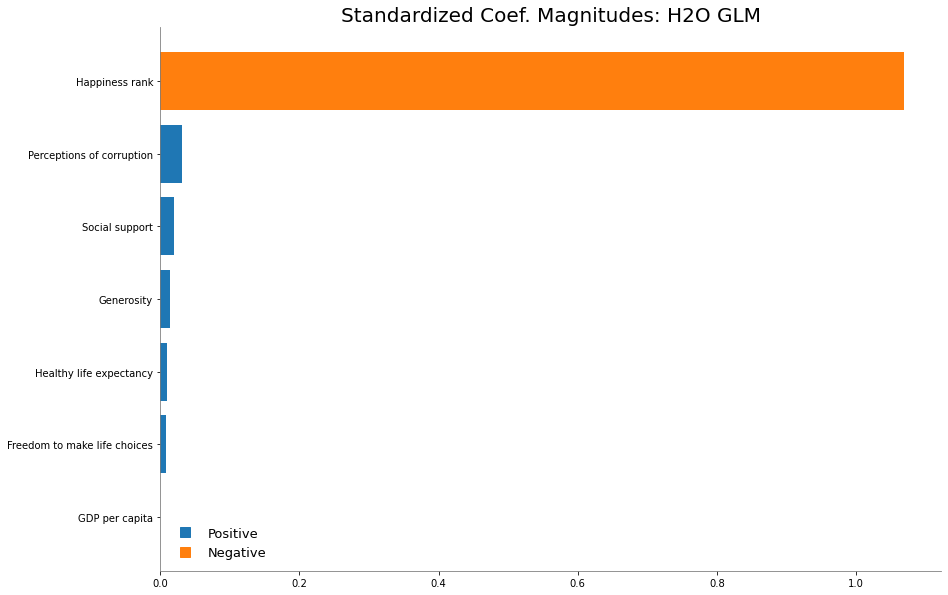

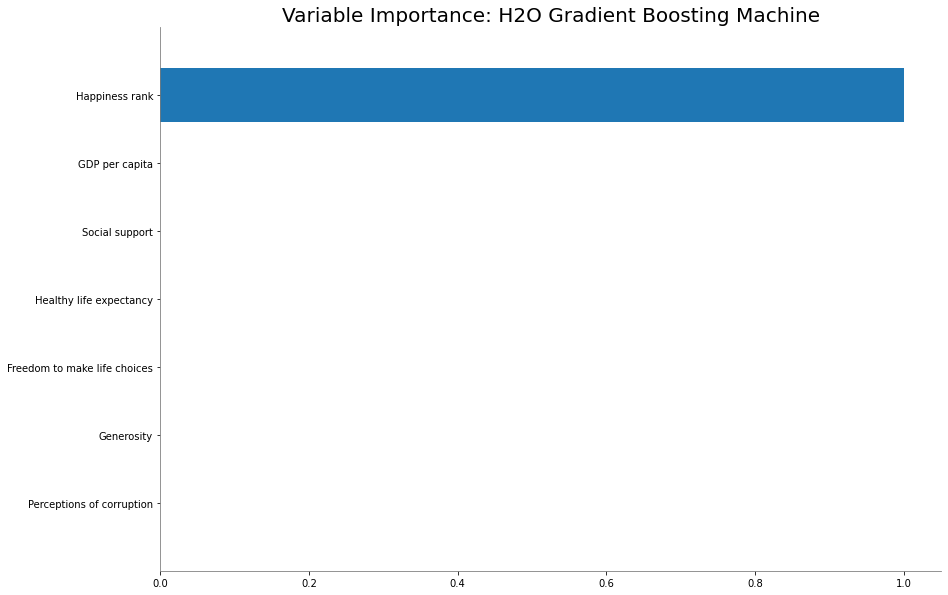

<Figure size 432x288 with 0 Axes>

In [108]:
data_glm.std_coef_plot()
data_gbm.varimp_plot()

In [109]:
# Model performance of GBM model on test data
data_gbm.model_performance(test)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.5024065489217573
RMSE: 0.7088064255646652
MAE: 0.5182240801007487
RMSLE: 0.11635565089345037
Mean Residual Deviance: 0.5024065489217573

## Pause.. it is important to check that output and understand it. Key is know your data best to validate the results
What you think was not normal in above plots ?? 
Happniess Rank as standard deviation as 1 ?? How is that possible ? 

Happiness Rank cannot be used because its like having measure for other country to measure other country. Lets now remove the happiness rank and see difference !! 

In [110]:
data = data[
    [
        "GDP per capita",
        "Social support",
        "Healthy life expectancy",
        "Freedom to make life choices",
        "Generosity",
        "Perceptions of corruption",
        "Happiness Score",
    ]
]

In [111]:
# Create a test/train split
train, test = data.split_frame([0.9])

In [112]:
#  Set response variable and your choice of predictor variables
myY = "Happiness Score"
myX = [
    "GDP per capita",
    "Social support",
    "Healthy life expectancy",
    "Freedom to make life choices",
    "Generosity",
    "Perceptions of corruption",
]

In [113]:
# Build simple GLM model
data_glm = H2OGeneralizedLinearEstimator(family="gaussian", standardize=True)
data_glm.train(x=myX, y=myY, training_frame=train, validation_frame=test)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1676328250563_57


GLM Model: summary
    family    link      regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.001789 )  6                             6                              1                       py_86_sid_9349

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.29129536971917264
RMSE: 0.5397178612193343
MAE: 0.4189641914454402
RMSLE: 0.08981661946968558
Mean Residual Deviance: 0.29129536971917264
R^2: 0.7741061175669292
Null degrees of freedom: 695
Residual degrees of freedom: 689
Null deviance: 897.5080473222844
Residual deviance: 202.74157732454415
AIC: 1132.7038510004572

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.3736471814450831
RMSE: 0.6112668659800587
MAE: 0.4951015564926557
RMSLE: 0.09612503886044824
Mean Residual Deviance: 0.3736471814450831
R^2: 0.6620337575643623
Null degrees of freedom: 85
Residual degrees of freedom: 79
Null deviance: 95.28950164013189
Residual deviance: 32.13365760427715
AIC: 175.3953046046542

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective           training_rmse       training_deviance    training_mae        training_r2         validation_rmse     validation_deviance    validation_mae      validation_r2
--  -------------------  ----------  ------------  -------------------------  ------------------  ------------------  -------------------  ------------------  ------------------  ------------------  ---------------------  ------------------  ------------------
    2023-02-14 01:16:52  0.000 sec   0             897.5080459954572          1.2895230545911742
    2023-02-14 01:16:52  0.003 sec   1                                                            0.5397178612193343  0.29129536971917264  0.4189641914454402  0.7741061175669292  0.6112668659800587  0.3736471814450831     0.4951015564926557  0.6620337575643623

Variable Importances: 
variable                      relative_importance    scaled_importance    percentage
----------------------------  ---------------------  -------------------  ------------
GDP per capita                0.463153               1                    0.349275
Freedom to make life choices  0.247837               0.535109             0.1869
Healthy life expectancy       0.239053               0.516144             0.180276
Social support                0.224618               0.484976             0.16939
Perceptions of corruption     0.0874129              0.188734             0.0659202
Generosity                    0.0639662              0.13811              0.0482385

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [114]:
# Build simple GBM model

data_gbm = H2OGradientBoostingEstimator(
    balance_classes=True, ntrees=10, max_depth=1, learn_rate=0.1, min_rows=2
)

data_gbm.train(x=myX, y=myY, training_frame=train, validation_frame=test)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,10.0,10.0,826.0,1.0,1.0,1.0,2.0,2.0,2.0
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2023-02-14 01:16:52,0.007 sec,0.0,1.1355717,0.9471439,1.2895231,1.0526241,0.8673430,1.1080175
,2023-02-14 01:16:52,0.014 sec,1.0,1.0835256,0.8965448,1.1740278,1.0088065,0.8294731,1.0176906
,2023-02-14 01:16:52,0.016 sec,2.0,1.0380442,0.8564959,1.0775358,0.9632496,0.7896559,0.9278498
,2023-02-14 01:16:52,0.019 sec,3.0,0.9961594,0.8182727,0.9923335,0.9287749,0.7549363,0.8626229
,2023-02-14 01:16:52,0.022 sec,4.0,0.9586686,0.7854621,0.9190455,0.8941116,0.7301998,0.7994356
,2023-02-14 01:16:52,0.025 sec,5.0,0.9244984,0.7535869,0.8546974,0.8650654,0.7027550,0.7483381
,2023-02-14 01:16:52,0.027 sec,6.0,0.8940080,0.7264983,0.7992503,0.8396326,0.6755704,0.7049830
,2023-02-14 01:16:52,0.029 sec,7.0,0.8657261,0.7018839,0.7494817,0.8142261,0.6557632,0.6629641


In [115]:
# Variable importances from each algorithm
# Calculate magnitude of normalized GLM coefficients
from six import iteritems

glm_varimp = data_glm.coef_norm()
for k, v in iteritems(glm_varimp):
    glm_varimp[k] = abs(glm_varimp[k])

# Sort in descending order by magnitude
glm_sorted = sorted(glm_varimp.items(), key=operator.itemgetter(1), reverse=True)
table = tabulate(
    glm_sorted, headers=["Predictor", "Normalized Coefficient"], tablefmt="orgtbl"
)
print("Variable Importances:\n\n" + table)

data_glm.varimp()
data_gbm.varimp()

Variable Importances:

| Predictor                    |   Normalized Coefficient |
|------------------------------+--------------------------|
| Intercept                    |                5.37358   |
| GDP per capita               |                0.463153  |
| Freedom to make life choices |                0.247837  |
| Healthy life expectancy      |                0.239053  |
| Social support               |                0.224618  |
| Perceptions of corruption    |                0.0874129 |
| Generosity                   |                0.0639662 |


[('GDP per capita', 1444.3883056640625, 1.0, 0.6003778711946939),
 ('Healthy life expectancy',
  961.410400390625,
  0.6656176850923846,
  0.39962212880530606),
 ('Social support', 0.0, 0.0, 0.0),
 ('Freedom to make life choices', 0.0, 0.0, 0.0),
 ('Generosity', 0.0, 0.0, 0.0),
 ('Perceptions of corruption', 0.0, 0.0, 0.0)]

In [116]:
dir(data_glm)

['HGLM',
 'Lambda',
 '_H2OEstimator__default_params',
 '_ModelBase__generate_partial_plots',
 '_ModelBase__generate_user_splits',
 '_ModelBase__grab_values',
 '_ModelBase__plot_1d_pdp',
 '_ModelBase__plot_1d_pdp_multinomial',
 '_ModelBase__plot_2d_pdp',
 '_ModelBase__pred_for_3d',
 '_ModelBase__set_axs_1d',
 '_ModelBase__set_axs_1d_multinomial',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_allowed_metrics',
 '_allowed_metrics_',
 '_bc',
 '_bci',
 '_check_and_save_parm',
 '_check_targets',
 '_default_metric',
 '_default_metrics_',
 '_default_param_value',
 '_end_time',
 '_estimator_type',
 '_extract_scoring_history',
 '_fillMultinomi

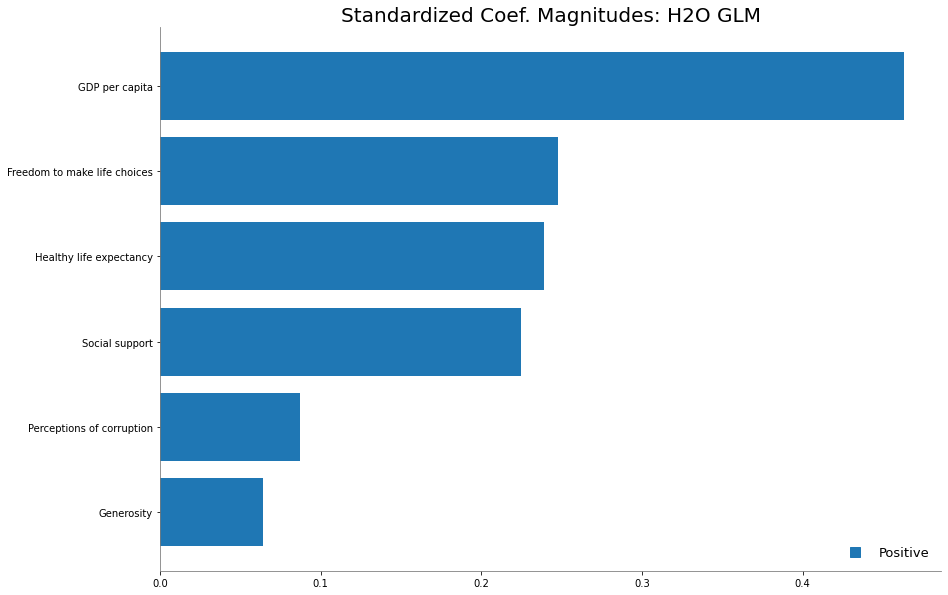

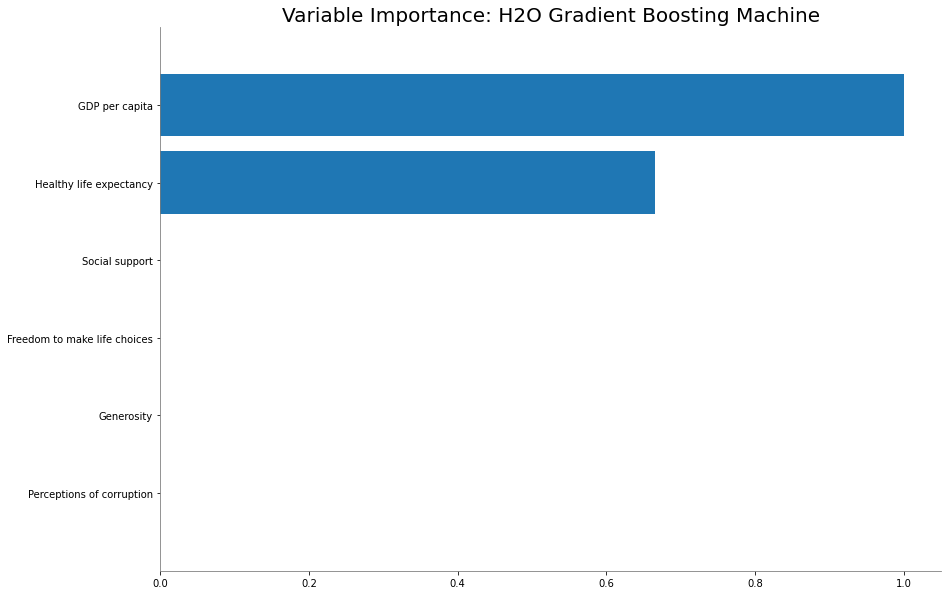

<Figure size 432x288 with 0 Axes>

In [117]:
data_glm.std_coef_plot()
data_gbm.varimp_plot()

In [118]:
# Model performance of GBM model on test data
data_gbm.model_performance(test)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.5735717524262874
RMSE: 0.7573452003058364
MAE: 0.6124506804873828
RMSLE: 0.12060360814767974
Mean Residual Deviance: 0.5735717524262874

In [119]:
def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ and name != "Happiness rank"]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == "enum":
                enums.append(key)
            elif val == "int":
                ints.append(key)
            else:
                reals.append(key)
    x = ints + enums + reals
    return x

In [120]:
train

GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Happiness Score
1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,7.587
1.30232,1.40223,0.94784,0.62877,0.4363,0.14145,7.561
1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,7.527
1.459,1.33095,0.88521,0.66973,0.34699,0.36503,7.522
1.32629,1.32261,0.90563,0.63297,0.45811,0.32957,7.427
1.29025,1.31826,0.88911,0.64169,0.23351,0.41372,7.406
1.32944,1.28017,0.89284,0.61576,0.4761,0.31814,7.378
1.33171,1.28907,0.91087,0.6598,0.36262,0.43844,7.364
1.25018,1.31967,0.90837,0.63938,0.47501,0.42922,7.286
1.33358,1.30923,0.93156,0.65124,0.43562,0.35637,7.284


In [121]:
X = get_independent_variables(train, myY)
print(X)
print(myY)

['GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']
Happiness Score


In [122]:
print(train.columns)

['GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Happiness Score']


In [123]:
# Set up AutoML
run_time = 333
aml = H2OAutoML(max_runtime_secs=run_time)

In [124]:
model_start_time = time.time()

aml.train(x=X, y=myY, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DRF base models (used / total),2/2
# GLM base models (used / total),0/1
# DeepLearning base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [125]:
execution_time = time.time() - model_start_time
print(execution_time)

332.9921717643738


In [126]:
print(aml.leaderboard)

model_id                                                             rmse       mse       mae      rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_3_AutoML_2_20230214_11653           0.466936  0.21803   0.363297  0.0775368                  0.21803
StackedEnsemble_AllModels_6_AutoML_2_20230214_11653              0.467163  0.218242  0.362554  0.0773757                  0.218242
StackedEnsemble_BestOfFamily_6_AutoML_2_20230214_11653           0.46724   0.218314  0.361609  0.0774906                  0.218314
StackedEnsemble_BestOfFamily_4_AutoML_2_20230214_11653           0.468191  0.219203  0.364385  0.0776889                  0.219203
StackedEnsemble_AllModels_2_AutoML_2_20230214_11653              0.468527  0.219518  0.364455  0.0778079                  0.219518
XRT_1_AutoML_2_20230214_11653                                    0.468584  0.219571  0.367078  0.0779249                  0.219571
StackedEnsemble_AllModels_1_AutoML_2_20230214_11653              0.472055  0.222836 

In [127]:
dir(aml)

['_H2OAutoML__frozen',
 '_H2OAutoML__input',
 '_H2OAutoML__validate_algo_parameters',
 '_H2OAutoML__validate_distribution',
 '_H2OAutoML__validate_frame',
 '_H2OAutoML__validate_modeling_plan',
 '_H2OAutoML__validate_monotone_constraints',
 '_H2OAutoML__validate_nfolds',
 '_H2OAutoML__validate_not_set',
 '_H2OAutoML__validate_preprocessing',
 '_H2OAutoML__validate_project_name',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_algo_parameters',
 '_build_resp',
 '_custom_distribution_func',
 '_event_log',
 '_fetch',
 '_huber_alpha',
 '_job',
 '_leader_id',
 '_leaderboard',
 '_poll_training_updates',
 '_quantile_alpha',
 '_state_json',
 '_training_info',
 '_tweedie_powe

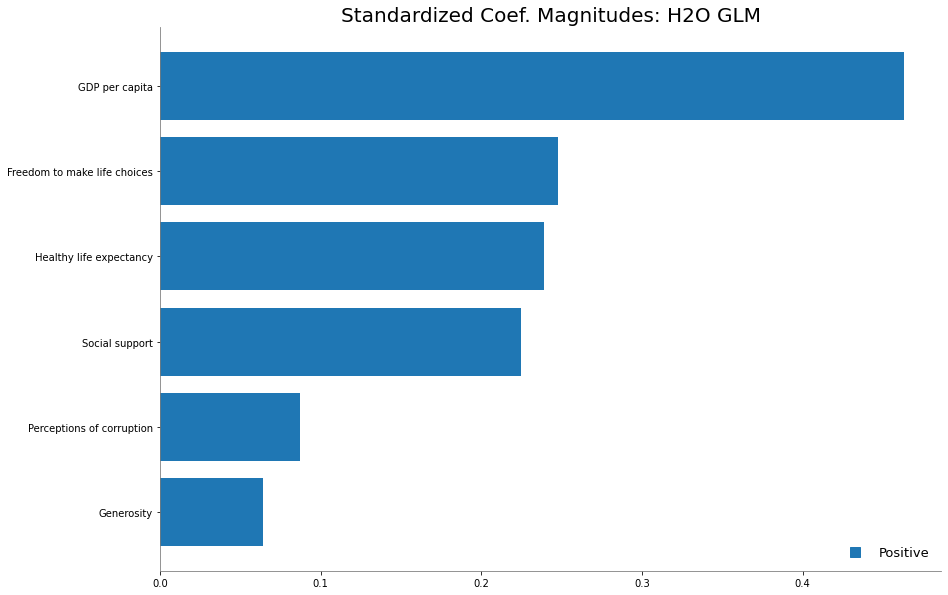

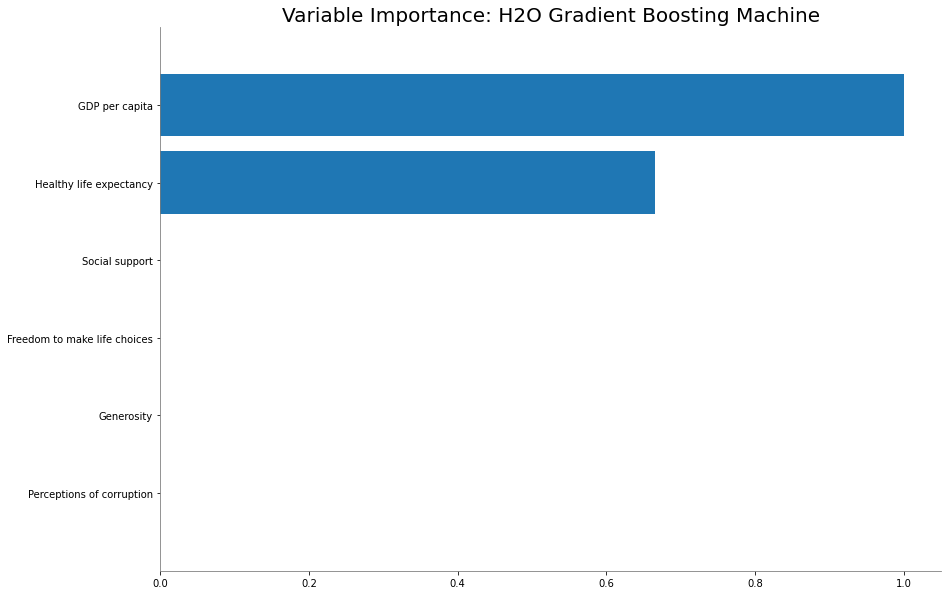

<Figure size 432x288 with 0 Axes>

In [128]:
data_glm.std_coef_plot()
data_gbm.varimp_plot()

In [129]:
best_model = h2o.get_model(aml.leaderboard[0, "model_id"])

In [130]:
best_model.algo

'stackedensemble'

In [131]:
if best_model.algo in ["xgboost", "drf", "gbm", "xgboost"]:
    best_model.varimp_plot()
else:
    print(best_model.params)

{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'StackedEnsemble_BestOfFamily_3_AutoML_2_20230214_11653', 'type': 'Key<Model>', 'URL': '/3/Models/StackedEnsemble_BestOfFamily_3_AutoML_2_20230214_11653'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_2_20230214_11653_training_py_86_sid_9349', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_2_20230214_11653_training_py_86_sid_9349'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_2_20230214_11653_training_py_86_sid_9349', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_2_20230214_11653_training_py_86_sid_9349'}}, 'response_column': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ColSpecifierV3', 'schema_type': 'VecSpecifier'}, 'c

Lets Check Best Variables for DRF 

In [132]:
nineth_best_model = h2o.get_model(aml.leaderboard[8, "model_id"])
nineth_best_model.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,GDP per capita,6694.896973,1.000000,0.331093
1,Healthy life expectancy,6171.747070,0.921858,0.305221
2,Social support,2958.755615,0.441942,0.146324
3,Freedom to make life choices,2109.210449,0.315047,0.104310
4,Perceptions of corruption,1574.946167,0.235246,0.077888
5,Generosity,711.029297,0.106205,0.035164


In [133]:
nineth_best_model.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,GDP per capita,6694.896973,1.000000,0.331093
1,Healthy life expectancy,6171.747070,0.921858,0.305221
2,Social support,2958.755615,0.441942,0.146324
3,Freedom to make life choices,2109.210449,0.315047,0.104310
4,Perceptions of corruption,1574.946167,0.235246,0.077888
5,Generosity,711.029297,0.106205,0.035164


In [134]:
h2o.cluster().shutdown()

H2O session _sid_9349 closed.


LICENSE
MIT License

Copyright (c) 2022 AI Skunks

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.